In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split

# Load data

In [3]:
# File paths
image_dir = '../images'
labels_df = pd.read_csv('../labels.csv')

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

labels_df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


# Data Inspection

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 1. Data info
print("Dataframe Information:")
print(labels_df.info())

Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17509 entries, 0 to 17508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  17509 non-null  object
 1   Label     17509 non-null  int64 
 2   Species   17509 non-null  object
dtypes: int64(1), object(2)
memory usage: 410.5+ KB
None


In [6]:
# 2. Check for duplicates in the 'Filename' column (if any)
duplicates = labels_df[labels_df.duplicated(subset=['Filename'])]
print(f"\nNumber of duplicate filenames: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates.head())


Number of duplicate filenames: 0


In [7]:
# 3. Corresponding species to each label
pair = labels_df[['Label', 'Species']].drop_duplicates().sort_values(by='Label')
print(pair.to_string(index=False))

 Label        Species
     0   Chinee apple
     1        Lantana
     2    Parkinsonia
     3     Parthenium
     4 Prickly acacia
     5    Rubber vine
     6      Siam weed
     7     Snake weed
     8       Negative


 Label        Species  Count
     0   Chinee apple   1125
     1        Lantana   1064
     2    Parkinsonia   1031
     3     Parthenium   1022
     4 Prickly acacia   1062
     5    Rubber vine   1009
     6      Siam weed   1074
     7     Snake weed   1016
     8       Negative   9106


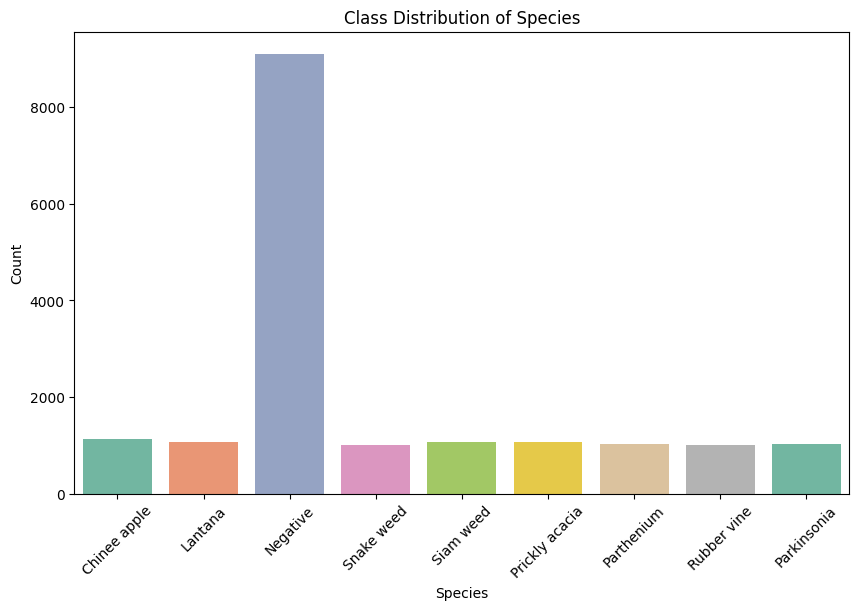

In [8]:
# 4. Class distribution

pair_count = labels_df.groupby(['Label', 'Species']).size().reset_index(name='Count')
pair_count_sorted = pair_count.sort_values(by='Label')

print(pair_count_sorted.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.countplot(x='Species', data=labels_df, hue='Species', palette='Set2')
plt.title('Class Distribution of Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Dealing with imbalance data

To mitigate class imbalance, I will randomly select Negative instances (Label is 8) to balance with other classes.

In [9]:
# Calculate the average number of rows for labels 0 to 7
filtered_df = labels_df[labels_df['Label'].between(0, 7)]
label_counts = filtered_df['Label'].value_counts()
average_count = int(label_counts.mean())  # Convert to integer for sampling

# Filter rows with label 8
negative_df = labels_df[labels_df['Label'] == 8]

# Randomly select `average_count` rows from label 8
selected_negative = negative_df.sample(n=average_count, random_state=42)

# Combine the selected label 8 rows with the rest of the data (excluding extra label 8 rows)
labels_df = pd.concat([filtered_df, selected_negative])

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

In [10]:
# Check the distribution after balancing the dataset

pair_count = labels_df.groupby(['Label', 'Species']).size().reset_index(name='Count')
pair_count_sorted = pair_count.sort_values(by='Label')

print(pair_count_sorted.to_string(index=False))


 Label        Species  Count
     0   Chinee apple   1125
     1        Lantana   1064
     2    Parkinsonia   1031
     3     Parthenium   1022
     4 Prickly acacia   1062
     5    Rubber vine   1009
     6      Siam weed   1074
     7     Snake weed   1016
     8       Negative   1050


# Train test split

I didn't split train data into train and validation dataset to utilize cross validation later when training models.

In [11]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, stratify=y, random_state=42)

# Create label-to-species mapping for displaying label counts
label_to_species = dict(zip(labels_df['Label'], labels_df['Species']))

# Label distribution
def print_label_distribution(y_train, y_test, label_to_species):
    # Create label counts for train and test datasets
    train_label_counts = pd.Series(y_train).value_counts().reset_index()
    test_label_counts = pd.Series(y_test).value_counts().reset_index()

    # Rename columns
    train_label_counts.columns = ['Label', 'Count']
    test_label_counts.columns = ['Label', 'Count']

    # Map species to the label counts
    train_label_counts['Species'] = train_label_counts['Label'].map(label_to_species)
    test_label_counts['Species'] = test_label_counts['Label'].map(label_to_species)

    # Display the distributions
    print("Training dataset distribution:")
    print(train_label_counts.to_string(index=False))

    print("\nTesting dataset distribution:")
    print(test_label_counts.to_string(index=False))

print_label_distribution(y_train, y_test, label_to_species)

Training dataset distribution:
 Label  Count        Species
     0    900   Chinee apple
     6    859      Siam weed
     1    851        Lantana
     4    849 Prickly acacia
     8    840       Negative
     2    825    Parkinsonia
     3    818     Parthenium
     7    813     Snake weed
     5    807    Rubber vine

Testing dataset distribution:
 Label  Count        Species
     0    225   Chinee apple
     6    215      Siam weed
     4    213 Prickly acacia
     1    213        Lantana
     8    210       Negative
     2    206    Parkinsonia
     3    204     Parthenium
     7    203     Snake weed
     5    202    Rubber vine


# Pre-processing (resizing, normalization, edge detection)

In [12]:
import tensorflow as tf
import numpy as np
import cv2  # For edge detection

# Function to load and decode images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    return image

# Preprocess image: resize and normalize
def preprocess_image(image, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)  # Resize image to the target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Edge detection using Canny or Sobel
def edge_detection(image):
    # Convert Tensor to NumPy array for edge detection
    image = image.numpy()  # Convert image to NumPy array
    
    # Convert the image to uint8 (necessary for Canny edge detection)
    image = (image * 255).astype(np.uint8)  # Scale back to [0, 255] and cast to uint8
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)  # Apply Canny edge detection
    edges = np.expand_dims(edges, axis=-1)  # Add channel dimension back to make it 3D (HxWx1)
    edges = np.repeat(edges, 3, axis=-1)  # Repeat the edge detection result across all 3 channels (RGB)
    return edges

# Create the dataset for training and testing
def create_dataset(image_paths, labels, batch_size=32, augment=False):
    X_processed = []
    y_processed = []

    for image_path, label in zip(image_paths, labels):
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Apply edge detection
        image_with_edges = tf.py_function(edge_detection, [image], tf.float32)
        
        # Append processed image and label
        X_processed.append(image_with_edges)
        y_processed.append(label)

    # Convert lists to NumPy arrays for further use
    X_processed = np.array(X_processed)
    y_processed = np.array(y_processed)

    return X_processed, y_processed

X_train_processed, y_train_processed = create_dataset(X_train, y_train)
X_test_processed, y_test_processed = create_dataset(X_test, y_test)


# Feature Extraction

### Feature extraction functions

In [13]:
import tensorflow as tf
import numpy as np
import cv2
from skimage.feature import local_binary_pattern

# Calculate the mean RGB values  
def mean_rgb_array(image):
    return np.mean(image, axis=(0, 1))  # Mean along height and width

# Compute Local Binary Pattern (LBP) features 
def lbp_features(image, radius=1, n_points=8):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    
    # Return the histogram of LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize histogram
    return np.mean(hist) # mean of the LBP histogram 

# Compute the mean value of the Laplacian 
def laplacian_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    return np.mean(np.abs(laplacian))  # Return mean of absolute Laplacian values

# Compute the mean value of edges in an image using Canny edge detection 
def edge_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    return np.mean(edges)  # Mean edge intensity

# Compute the mean value of Harris corner strengths 
def corner_mean_value(image, block_size=2, ksize=3, k=0.04):
    """
    Parameters:
    - block_size: The size of the neighborhood considered for corner detection.
    - ksize: Aperture parameter of the Sobel derivative used.
    - k: Harris detector free parameter in the equation.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.float32(gray_image)  # Convert to float32 for cornerHarris

    # Apply Harris corner detection
    corners = cv2.cornerHarris(gray_image, block_size, ksize, k)
    
    # Normalize the corner response to the range [0, 1]
    corners_normalized = cv2.normalize(corners, None, 0, 1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the mean value of corner strengths
    mean_corner_strength = np.mean(corners_normalized)
    
    return mean_corner_strength

### Apply Feature Extraction Functions

In [14]:
# Extract features for a single image
def extract_features(image):
    # Convert Tensor to NumPy array for processing
    image_np = image.numpy()
    image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255]
    
    # Extract features
    features = {
        "rgb_mean": mean_rgb_array(image_np),  # Mean RGB values
        "lbp_mean": lbp_features(image_np),  # Local Binary Pattern histogram
        "laplacian_mean": laplacian_mean_value(image_np),  # Mean Laplacian value
        "edge_mean": edge_mean_value(image_np),  # Mean edge intensity
        "corner_mean": corner_mean_value(image_np),  # Mean corner strength
    }
    return features

# Final Feature Extraction
def extract_features_from_dataset(image_paths):
    feature_list = []
    for image_path in image_paths:
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Extract features
        features = extract_features(image)
        feature_list.append(features)
    
    return feature_list

### Feature Extraction on Training Data 

In [15]:
train_extracted_features = np.array(extract_features_from_dataset(X_train))
print(train_extracted_features)

[{'rgb_mean': array([78.0228396 , 79.32079082, 77.62215003]), 'lbp_mean': np.float64(0.0999999999998007), 'laplacian_mean': np.float64(94.46012037627551), 'edge_mean': np.float64(82.7164381377551), 'corner_mean': np.float32(0.28835854)}
 {'rgb_mean': array([93.94533243, 90.40156649, 82.38813377]), 'lbp_mean': np.float64(0.09999999999980069), 'laplacian_mean': np.float64(37.626395089285715), 'edge_mean': np.float64(61.70699139030612), 'corner_mean': np.float32(0.36601585)}
 {'rgb_mean': array([77.92165577, 90.9279536 , 84.08725287]), 'lbp_mean': np.float64(0.09999999999980069), 'laplacian_mean': np.float64(85.49447943239795), 'edge_mean': np.float64(91.84390943877551), 'corner_mean': np.float32(0.19910921)}
 ...
 {'rgb_mean': array([86.73427535, 93.06580835, 81.62820871]), 'lbp_mean': np.float64(0.0999999999998007), 'laplacian_mean': np.float64(68.41095344387755), 'edge_mean': np.float64(86.4111328125), 'corner_mean': np.float32(0.41705394)}
 {'rgb_mean': array([99.25117586, 79.62017698

In [16]:
# Flatten the image data
X_train_flattened = X_train_processed.reshape(X_train_processed.shape[0], -1)

In [17]:
train_features_list = []
for feature in train_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    train_features_list.append(features)

# Convert the list of features into a numpy array
train_extracted_features_array = np.array(train_features_list)

# Concatenate the image data with the extracted features
X_train_final = np.concatenate([X_train_flattened, train_extracted_features_array], axis=1)
y_train_final = y_train_processed

#### Feature Extraction on Testing Data

In [18]:
test_extracted_features = np.array(extract_features_from_dataset(X_test))

X_test_flattened = X_test_processed.reshape(X_test_processed.shape[0], -1)

test_features_list = []
for feature in test_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    test_features_list.append(features)

# Convert the list of features into a numpy array
test_extracted_features_array = np.array(test_features_list)

# Concatenate the image data with the extracted features
X_test_final = np.concatenate([X_test_flattened, test_extracted_features_array], axis=1)
y_test_final = y_test_processed

# PCA Vs. LDA

## PCA

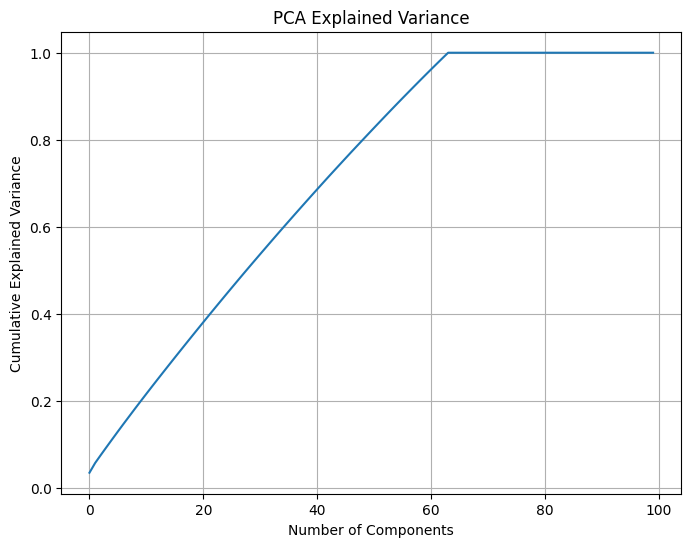

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import cv2

# Resize images to reduce memory usage
X_train_resized = np.array([cv2.resize(img, (64, 64)) for img in X_train_final])

# Flatten the images (if they are 3D) into 1D arrays for LDA
X_train_flattened = X_train_resized.reshape(X_train_resized.shape[0], -1)

# 1. Standardize the data (scale to zero mean and unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_flattened)

# 2. Apply LDA
ipca = IncrementalPCA(n_components=100, batch_size=500)  # Adjust components and batch size
X_train_pca = ipca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(ipca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [20]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_scaled)

explained_variance_pca = np.cumsum(pca.explained_variance_ratio_)

# Define the threshold for explained variance 
threshold = 0.9999

# Find the optimal number of components
optimal_components_pca = np.argmax(explained_variance_pca >= threshold) + 1

print(f"Optimal number of components to retain {threshold*100:.0f}% variance: {optimal_components_pca}")

Optimal number of components to retain 100% variance: 64


In [ ]:
apply_PCA = False

if apply_PCA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    pca = PCA(n_components=64, random_state=42)
    X_train_final = pca.fit_transform(X_train_final)
    X_test_final = pca.transform(X_test_final)

    print(f'Reduced number of features after PCA: {X_train_final.shape[1]}')

NameError: name 'X_train_final' is not defined

## LDA

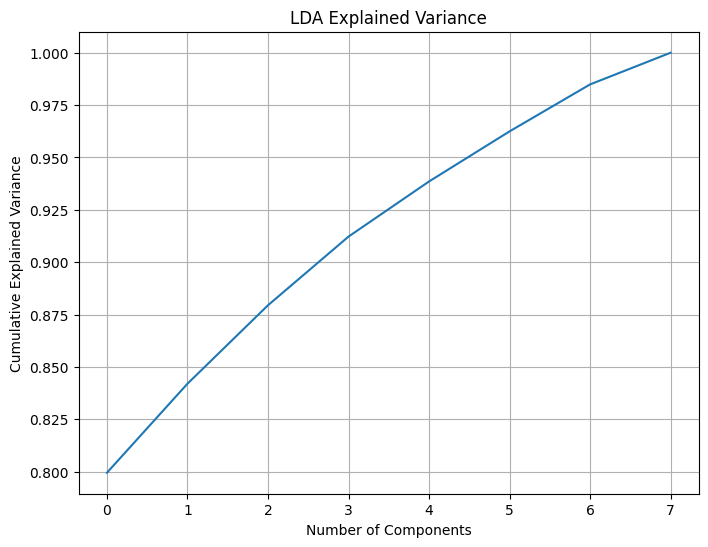

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Resize images to reduce memory usage
X_train_resized = np.array([cv2.resize(img, (64, 64)) for img in X_train_final])

# Flatten the images (if they are 3D) into 1D arrays for LDA
X_train_flattened = X_train_resized.reshape(X_train_resized.shape[0], -1)

# 1. Standardize the data (scale to zero mean and unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_flattened)

# 2. Apply LDA
lda = LinearDiscriminantAnalysis(n_components=8)
X_train_lda = lda.fit_transform(X_scaled, y_train)

# 3. Create a plot for the cumulative explained variance ratio
plt.figure(figsize=(8, 6))

# LDA doesn't directly provide the cumulative explained variance like PCA
# However, you can plot the variance explained by each component (as LDA provides this)
explained_variance_ratio = lda.explained_variance_ratio_

# Plot the cumulative sum of explained variance 
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('LDA Explained Variance')
plt.grid(True)
plt.show()


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_scaled, y_train)

explained_variance_lda = np.cumsum(lda.explained_variance_ratio_)

# Define the threshold for explained variance 
threshold = 0.9999

# Find the optimal number of components
optimal_components_lda = np.argmax(explained_variance_lda >= threshold) + 1

print(f"Optimal number of components to retain {threshold*100:.0f}% variance: {optimal_components_lda}")

Optimal number of components to retain 100% variance: 8


In [25]:
apply_LDA = True

if apply_LDA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    lda = LinearDiscriminantAnalysis(n_components=8)
    X_train_final = lda.fit_transform(X_train_final, y_train_final)
    X_test_final = lda.transform(X_test_final)

    print(f'Reduced number of features after PCA: {X_train_final.shape[1]}')

Original number of features: 150535


: 

Determined to use which one because blabla